In [1]:
import numpy as np
from numpy.lib.recfunctions import append_fields
from numpy.lib.recfunctions import recursive_fill_fields
import numba

import matplotlib.pyplot as plt
import matplotlib as mpl
import uproot
import pyjet
import time

from matching import matching
import sum4 as sum4

import mpmath
np_cosh = np.frompyfunc(mpmath.cosh, 1, 1)
np_sinh = np.frompyfunc(mpmath.sinh, 1, 1)
np_log = np.frompyfunc(mpmath.log, 1, 1)

plt.style.use("scientific.mplstyle")

file = uproot.open("/eos/user/c/clange/PFNano/myNanoProdMc_NANO.root")
event_tree = file['Events']

In [2]:
max_idx = 200

pts = event_tree['PF_pt'].array(entry_stop=max_idx, library='np')
etas = event_tree['PF_eta'].array(entry_stop=max_idx, library='np')
phis = event_tree['PF_phi'].array(entry_stop=max_idx, library='np')
masses = event_tree['PF_mass'].array(entry_stop=max_idx, library='np')

pv_labels = event_tree['PF_fromPV'].array(entry_stop=max_idx, library='np')


recojet_pts = event_tree['Jet_pt'].array(entry_stop=max_idx, library='np')
recojet_etas = event_tree['Jet_eta'].array(entry_stop=max_idx, library='np')
recojet_phis = event_tree['Jet_phi'].array(entry_stop=max_idx, library='np')
recojet_masses = event_tree['Jet_mass'].array(entry_stop=max_idx, library='np')

raw_pt_factor = 1-event_tree['Jet_rawFactor'].array(entry_stop=max_idx, library='np')
pf_recojetidx = event_tree['PF_jetsIdx'].array(entry_stop=max_idx, library='np')

In [3]:
def pyjet_jet_clustering(pts, etas, phis, masses, pv_labels, R, ptmin):
    '''Cluster jets for one event with anti kt, 15 Gev pt cut off, and CHS. It is assumed that only particles with a vertex label > 0 are signal particles'''

    event_4vect = np.column_stack((pts, etas, phis, masses)).astype('float64')
    event = np.core.records.fromarrays(event_4vect.transpose(), dtype=pyjet.DTYPE_PTEPM)
    event = append_fields(event, 'id', data=np.arange(len(event))).data
    
    chs_mask = np.where(pv_labels>0, True, False)
    event = event[chs_mask]

    sequence = pyjet.cluster(event, R=R, p=-1)
    my_jets = sequence.inclusive_jets(ptmin=ptmin)
    
    return my_jets

In [4]:
class Node():
    '''Tree where a node represents a particle/pseudojet in the clustering process. 
    Leaf nodes represent PF candidates of an event, s.t. their label is the index of the PF candidate.
    The parents if a node are the two particles/pseudojets of the previous clustering stage which have been merged to form a new particle.'''
    
    def __init__(self, label, is_PF = False):
        self.label = label
        self.is_leaf = is_PF
        self.parents = []
        
    def add_parents(self, parent_node1, parent_node2):
        self.parents = [parent_node1, parent_node2]
        
    def get_leaf_labels(self):
        '''Return PF candiates which have been clustered to form this Node'''
        leaf_labels = []
        self._collect_leaf_nodes(self, leaf_labels)
        return leaf_labels
    
    def _collect_leaf_nodes(self, node, leaf_labels):
        if node.is_leaf:
            leaf_labels.append(node.label)
        for n in node.parents:
            self._collect_leaf_nodes(n, leaf_labels)

In [5]:
def rapidity(pt, eta, m):
    '''Accepts np.array or scalars for all inputs and returns rapidity in the format of the input'''
    return np_log((np.sqrt(m**2+pt**2*np_cosh(eta)**2) + pt*np_sinh(eta))/np.sqrt(m**2+pt**2))


@numba.vectorize
def anti_kt_dist(pt_i, pt_j, y_i, y_j, phi_i, phi_j, R):
    dphi = phi_i - phi_j
    dR2 = (y_i-y_j)**2 + ((dphi+np.pi)%(2*np.pi)-np.pi)**2
    
    return min(1/pt_i**2, 1/pt_j**2)*dR2/R**2
    
    
@numba.jit(nopython=True)
def keep_mask(pairs, del_idx):
    '''Returns bool array where elements are True if neither of the elements of in pairs is del_idx.
    Hence, apply as mask to extract values to keep'''
    a, b = pairs[0] != del_idx, pairs[1] != del_idx
    return np.logical_and(a,b)
    

    
def myown_jet_clustering(pts, etas, phis, ms, pv_labels, R, ptmin):
    '''Returns 2 lists. The first contains pt eta phi mass 4 vectors (as array) of found jets of the single event passed.
    The second list contains lists of the indicies of clustered PF candidates.'''
    jet = [] # 4 vectors of clustered jets
    
    # changing dtype of array elements to mpf for higher precision calculation
    pts = np.array([mpmath.mpf(str(p)) for p in pts])
    etas = np.array([mpmath.mpf(str(e)) for e in etas])
    phis = np.array([mpmath.mpf(str(p)) for p in phis])
    ms = np.array([mpmath.mpf(str(m)) for m in ms])
    
    # make structured array (pt, eta, phi, m, y, node) for every particle in event
    # collection of structured particles stored in event
    ys = rapidity(pts, etas, ms)
    id_nodes = [Node(i, is_PF=True) for i in range(len(pts))]
    event_4vect = np.column_stack((pts, etas, phis, ms)).astype('float64')
    event = np.core.records.fromarrays(event_4vect.transpose(), dtype=pyjet.DTYPE_PTEPM)
    event = append_fields(event, 'y', data=ys, dtypes='f8').data
    # make new data type to add field with Node instances
    dt = event.dtype.descr + [('id_node', 'O')]
    aux = np.empty(event.shape, dt) 
    event = recursive_fill_fields(event, aux)
    event['id_node'] = id_nodes
    
    chs_mask = np.where(pv_labels>0)[0]
    event = event[chs_mask]
    
    
    # Find distances for all initial particles. Afterwards only update values effected by merging or deleting particles
    pairs = np.triu_indices(len(event),k=1) # tuple of 2 arrays: values i and j indicies for upper triangular elements
    anti_kt_distance = anti_kt_dist(event['pT'][pairs[0]], event['pT'][pairs[1]], event['y'][pairs[0]], event['y'][pairs[1]], event['phi'][pairs[0]], event['phi'][pairs[1]], R)
    beam_distance = 1/event['pT']**2


    while len(event) > 1:   
#         #Assuming only one minima exists
#         min_id = np.argmin(anti_kt_distance)
#         min_anti_kt_d = anti_kt_distance[min_id]
#         min_ij = [pairs[0][min_id], pairs[1][min_id]]

#         min_idx = np.argmin(beam_distance) 
#         min_beam_d = beam_distance[min_idx]

        # Dealing with degenerate minima
        # choose particle pair with max pt
        min_anti_kt_d = np.min(anti_kt_distance)
        anti_kt_dmin_pair_idxs = np.where(anti_kt_distance==min_anti_kt_d)[0]
        if len(anti_kt_dmin_pair_idxs) > 1:
            pts_potential_pairs = event['pT'][pairs[0][anti_kt_dmin_pair_idxs]] + event['pT'][pairs[1][anti_kt_dmin_pair_idxs]]
            chosen_pair_id = np.argmax(pts_potential_pairs)
            min_id = anti_kt_dmin_pair_idxs[chosen_pair_id]
        else:
            min_id = anti_kt_dmin_pair_idxs[0]
            
        min_ij = [pairs[0][min_id], pairs[1][min_id]] # guarentees smaller index always first  
       
        # choose particle with larger mass
        min_beam_d = np.min(beam_distance)
        beam_dmin_idxs = np.where(beam_distance==min_beam_d)[0]
        if len(beam_dmin_idxs) > 1:
            chosen_min = np.argmax(event['mass'][beam_dmin_idxs])
            min_idx = beam_dmin_idxs[chosen_min]
        else:
            min_idx = beam_dmin_idxs[0]

            
        
        if (min_beam_d < min_anti_kt_d): # declare particle as jet if pt>=ptmin
            if event[min_idx]['pT'] >= ptmin:
                jet.append(event[min_idx])
            event = np.delete(event, min_idx, axis=0)
            # update pairs and distances
            particles_to_keep = keep_mask(pairs, min_idx)
            pairs = np.triu_indices(len(event),k=1)
            anti_kt_distance = anti_kt_distance[particles_to_keep] 
            beam_distance = np.delete(beam_distance, min_idx)
        else: # merge two particles together
            # find new 4 vector
            p1, p2 = event[min_ij[0]].tolist()[:4], event[min_ij[1]].tolist()[:4]
            aux = np.column_stack((p1,p2))
            new_vec4 = sum4.np_sum4vec(aux[0], aux[1], aux[2], aux[3])
            new_y = rapidity(new_vec4[0], new_vec4[1], new_vec4[3])
            # make new node
            parent_node1, parent_node2 = event['id_node'][min_ij[0]], event['id_node'][min_ij[1]] 
            new_node = Node(label=parent_node1.label) # smaller of the two parent labels
            new_node.add_parents(parent_node1, parent_node2)
            # change particle with smaller id to merged one
            event[min_ij[0]] = tuple(np.concatenate((new_vec4, [new_y, new_node])))
            
            # updates distances due to merge
            beam_distance[min_ij[0]] = 1/new_vec4[0]**2
            mask = keep_mask(pairs, min_ij[0])
            new_d_needed = np.invert(mask)
            p, q = pairs[0][new_d_needed], pairs[1][new_d_needed]
            # Only compute new anti-kt distance for pairs effected by merge of two particles. The remaining distances remain unchanged 
            # Needs improvement as distance to particle that will be deletet is still computed.
            anti_kt_distance[new_d_needed] = anti_kt_dist(event['pT'][p], event['pT'][q], event['y'][p], event['y'][q], event['phi'][p], event['phi'][q], R)

            # delete particle with smaller id
            event = np.delete(event, min_ij[1], axis=0)
            particles_to_keep = keep_mask(pairs, min_ij[1])
            pairs = np.triu_indices(len(event),k=1)
            anti_kt_distance = anti_kt_distance[particles_to_keep] 
            beam_distance = np.delete(beam_distance, min_ij[1])


    # deal with last particle
    if event[0]['pT'] >= ptmin:
        jet.append(event[0])
    event = np.delete(event, 0, axis=0)
            

    # deal with case when no jets exist
    if len(jet) == 0:
        return [], []     
    
    # TypeError occurs for event 67, 74, 138. Problematic is only the last element: TypeError: '<' not supported between instances of 'Node' and 'Node'
    try:
        jet = np.sort(np.array(jet), order=['pT', 'mass'])[::-1]
    except TypeError:
        print("-----\nSort error\n-----")
        jet_pts = [jet[0] for jet in jet]
        sorting_idxs = np.argsort(jet_pts)
        jet = np.array(jet)[sorting_idxs][::-1]
    

    # find PF constituents of every jet
    jets = np.empty(len(jet), dtype=pyjet.DTYPE_PTEPM)
    jet_consti = []
    for i, jet in enumerate(jet):
        jet_consti.append(np.sort(jet['id_node'].get_leaf_labels()))
        jets[i] = jet[['pT', 'eta', 'phi', 'mass']]
        
    
    return jets, jet_consti

In [6]:
ptmin = 15
jet_parameter = 0.4
cluster_time_myalgo, cluster_time_pyjet = [], []
same_consti_pyjet = [] # each element will be boolean list where each entry states wheter constituents of myjet are the same as in pyjet
# Difference of my clustered jets to jets clustered by pyjet, normalized to pyjet quantaties
dpt_pyjet, dR_pyjet, dmass_pyjet = [], [], []

for i in range(max_idx):
    print("Event ", i)
    t1 = time.time()
    pyjetjets = pyjet_jet_clustering(pts[i], etas[i], phis[i], masses[i], pv_labels[i], jet_parameter, ptmin)
    pyjets_consti = []
    for jet in pyjetjets:
        pyjets_consti.append(np.sort([consti.id for consti in jet]))
    t2 = time.time()
    #print(t2-t1)
    cluster_time_pyjet.append(t2-t1)

    t3 = time.time()
    myjets, myjets_consti = myown_jet_clustering(pts[i], etas[i], phis[i], masses[i], pv_labels[i], jet_parameter, ptmin)
    t4 = time.time()
    #print(t4-t3)
    cluster_time_myalgo.append(t4-t3)
    

    if len(myjets)==0:
        continue
    
    # find differences to pyjetjets
    pyjet_etas = [pyjetjet.eta for pyjetjet in pyjetjets]
    pyjet_phis = [pyjetjet.phi for pyjetjet in pyjetjets]
    matches_pyjet = matching(myjets['eta'], myjets['phi'], pyjet_etas, pyjet_phis)
    same_consti_this_event = []
    
    for p,q in enumerate(matches_pyjet): # (p,q) is tuple of myjet index and pyjet index, s.t. jet axis have minmal separation.
        if q == -1:
            print("Couldn't find fitting pyjet to myjet {} in event {}".format(p, i))
        else:
            dpt_pyjet.append((myjets[p]['pT'] - pyjetjets[q].pt)/pyjetjets[q].pt)
            dR_pyjet.append(np.sqrt((myjets[p]['eta'] - pyjetjets[q].eta)**2 + (myjets[p]['phi'] - pyjetjets[q].phi)**2))
            dmass_pyjet.append((myjets[p]['mass'] - pyjetjets[q].mass)/pyjetjets[q].mass)
            
            if len(myjets_consti[p]) == len(pyjets_consti[q]):
                same_consti_this_event.append(np.allclose(myjets_consti[p], pyjets_consti[q]))
            else:
                same_consti_this_event.append(False)
                print("Different number of constituents found in myjet {}, pyjet {} of event {}.\n\tMy algo: {} constituents\n\tPyjet : {} constituents".format(p, q, i, len(myjets_consti[p]), len(pyjets_consti[q])))
                
    same_consti_pyjet.append(same_consti_this_event)

Event  0
Event  1
Event  2
Event  3
Event  4
Event  5
Event  6
Event  7
Event  8
Event  9
Event  10
Event  11
Event  12
Event  13
Event  14
Event  15
Event  16
Event  17
Event  18
Event  19
Event  20
Event  21
Event  22
Event  23
Event  24
Event  25
Event  26
Event  27
Event  28
Event  29
Event  30
Event  31
Event  32
Event  33
Event  34
Event  35
Different number of constituents found in myjet 19, pyjet 18 of event 35.
	My algo: 15 constituents
	Pyjet : 16 constituents
Event  36
Event  37
Event  38
Event  39
Event  40
Event  41
Event  42
Event  43
Event  44
Event  45
Event  46
Event  47
Event  48
Event  49
Event  50
Event  51
Event  52
Event  53
Event  54
Event  55
Event  56
Event  57
Event  58
Event  59
Event  60
Event  61
Event  62
Event  63
Event  64
Event  65
Event  66
Event  67
-----
Sort error
-----
Event  68
Event  69
Event  70
Event  71
Event  72
Event  73
Event  74
-----
Sort error
-----
Event  75
Event  76
Event  77
Event  78
Event  79
Event  80
Event  81
Event  82
Event  83

In [19]:
n_notcorrect_pyjet = 0
for i,c in enumerate(same_consti_pyjet):
    n_notcorrect_pyjet += c.count(False)
    if False in c:
        print("Event: ", i)
        
n_notcorrect_pyjet

Event:  35
Event:  97
Event:  98
Event:  127


5

In [16]:
py_xlabels = ['$\\frac{myjet_{pt} - pyjet_{pt}}{pyjet_{pt}}$', '$\\frac{myjet_{m} - pyjet_{m}}{pyjet_{m}}$']
reco_xlabels = ['$\\frac{myjet_{pt} - recojet_{pt}}{recojet_{pt}}$', '$\\frac{myjet_{m} - recojet_{m}}{recojet_{m}}$']
img_names = ["plots/comparing_my_clustering_algo_pyjet_recojet/mycluster_algo_vs_pyjet_speedup_detail.pdf", "plots/comparing_my_clustering_algo_pyjet_recojet/mycluster_algo_vs_recojet_speedup.pdf"]

#plt.rcParams.update({'font.size': 10})

def plot_differences(dR, dpt, dm, same_consti, xlabels, img_name):
    fig, ax = plt.subplots(1,3, figsize=(26, 7))
    
    n_jets = len(dR)
    n_false_consti = 0
    for same_c in same_consti:
        n_false_consti += same_c.count(False)
        
    
    ax[0].hist(dR, bins=50, histtype='step')
    ax[0].text(0.4, 0.9, "\# considered events: {:.0f}\n\# compared jets: {:.0f}\nfrequency of correct constituents in \%: {:.2%}".format(max_idx, n_jets, 1-n_false_consti/n_jets), ha='left', va='top', transform = ax[0].transAxes)
    ax[0].set_title('Separation of jet axis')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('$\Delta R$')
    ax[0].set_ylabel('Counts')
    
    ax[1].hist(dpt, bins=50, histtype='step')
    ax[1].set_title('Normalized $\Delta pt$')
    ax[1].set_yscale('log')
    ax[1].set_xlabel(xlabels[0])
    ax[1].set_ylabel('Counts')
    
    ax[2].hist(dm, bins=50, histtype='step')
    ax[2].set_title('Normalized $\Delta m$')
    ax[2].set_yscale('log')
    ax[2].set_xlabel(xlabels[1])
    ax[2].set_ylabel('Counts')
    
    fig.savefig(img_name)

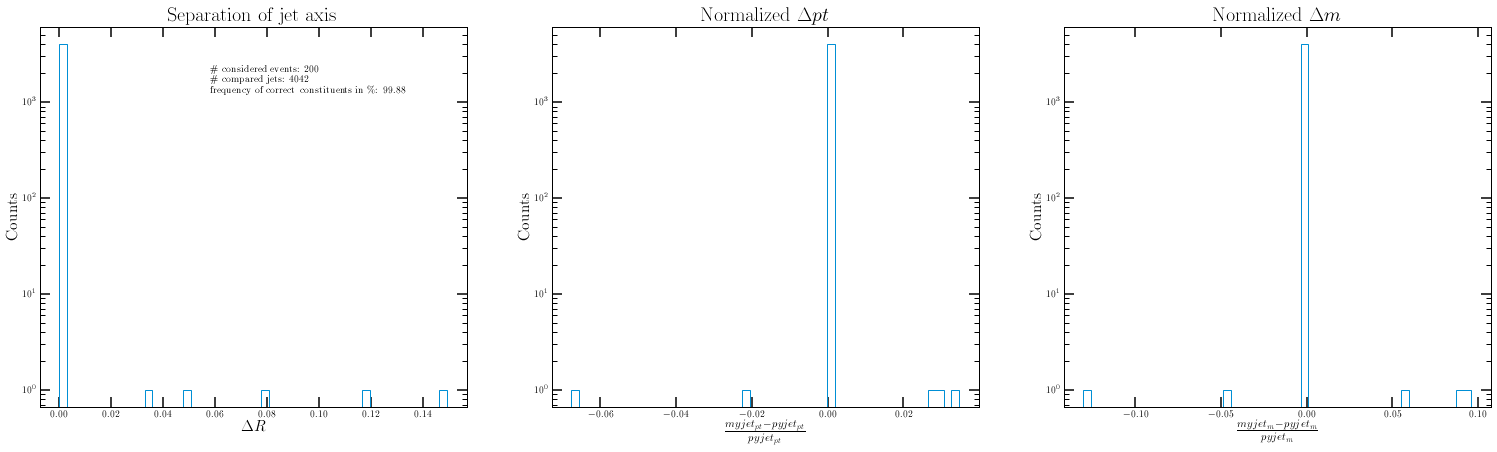

In [15]:
plot_differences(dR_pyjet, dpt_pyjet, dmass_pyjet, same_consti_pyjet, py_xlabels, img_names[0])

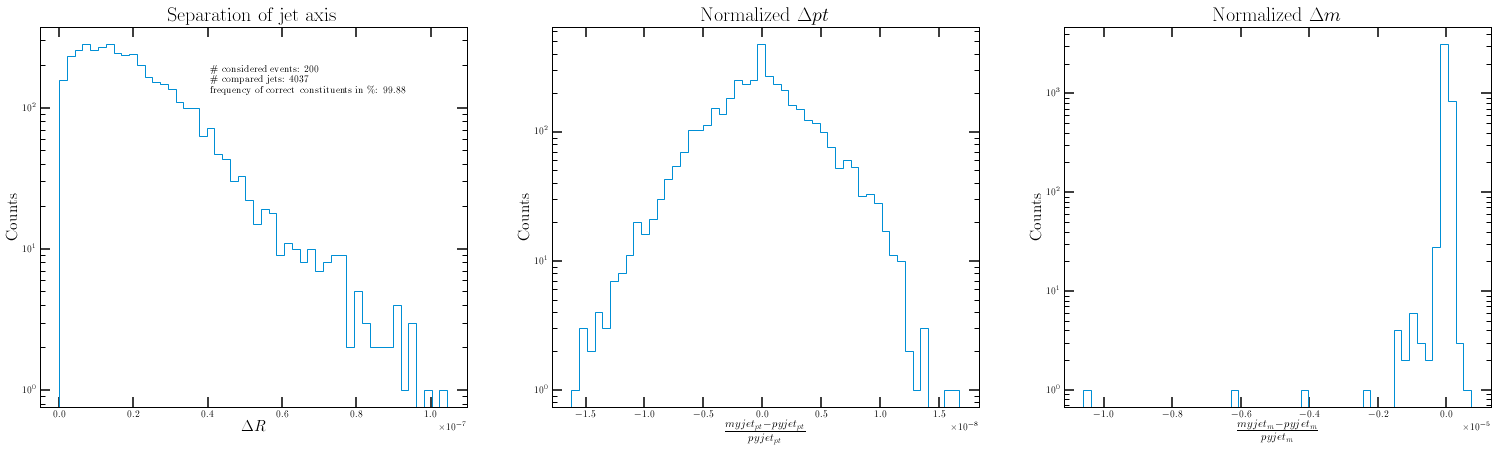

In [17]:
# make more detailed plots fro data points close to 0
mask = np.where(np.array(dR_pyjet)<0.001, True, False)
plot_differences(np.array(dR_pyjet)[mask], np.array(dpt_pyjet)[mask], np.array(dmass_pyjet)[mask], same_consti_pyjet, py_xlabels, img_names[0])

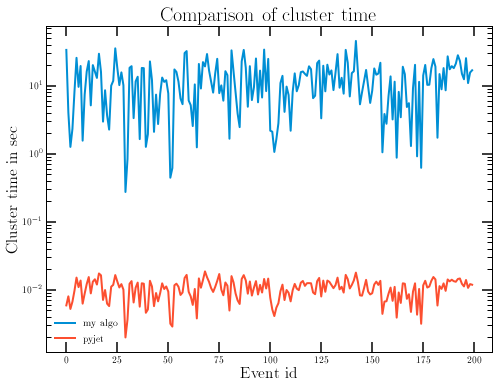

In [22]:
fig = plt.figure(figsize=(8,6))

plt.plot(np.arange(max_idx), cluster_time_myalgo, label='my algo')
plt.plot(np.arange(max_idx), cluster_time_pyjet, label='pyjet')
plt.legend()
plt.yscale('log')
plt.title('Comparison of cluster time')
plt.xlabel('Event id')
plt.ylabel('Cluster time in sec')
plt.show()

#fig.savefig("plots/comparing_my_clustering_algo_pyjet_recojet/clustertime_speedup.pdf")

In [19]:
print("My Algo: Total: {:.3f} sec\t mean per event: {:.3f} sec\nPyjet: Total: {:.3f} sec\t mean per event: {:.3f} sec".format(np.sum(cluster_time_myalgo), np.mean(cluster_time_myalgo), np.sum(cluster_time_pyjet), np.mean(cluster_time_pyjet)))

My Algo: Total: 2557.509 sec	 mean per event: 12.788 sec
Pyjet: Total: 2.109 sec	 mean per event: 0.011 sec


In [24]:
n_costi = [len(b) for b in same_consti_pyjet]
print(max(n_costi))

80
